In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [2]:
df = pd.read_csv('Data/costSensitive.csv')

In [3]:
df.columns

Index(['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN', 'Status', 'FNC'],
      dtype='object')

In [4]:
data = df.values
print(data.shape)

(147636, 13)


In [5]:
X = data[:, :-2]

# Normalize the data (Z-score)
X = (X - X.mean(axis=0)) / X.std(axis=0)

X.shape

(147636, 11)

In [6]:
y = data[:, -2]

y.shape

(147636,)

In [7]:
fnc = data[:, -1]

fnc.shape

(147636,)

In [8]:
# OBtaining the train, val, test loaders

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  
fnc_tensor = torch.tensor(fnc, dtype=torch.float32)

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size  

dataset = TensorDataset(X_tensor, y_tensor, fnc_tensor)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=147636, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=147636, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=147636, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader))

for (x, y, fnc) in train_loader:
    print(x.shape, y.shape, fnc.shape)
    break

103345 22145 22146
1 1 1
torch.Size([103345, 11]) torch.Size([103345]) torch.Size([103345])


In [28]:
class LogisticRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        
    def forward(self, x):
        y = self.linear(x)
        return y.reshape((y.shape[0],))

Epoch 0: train loss = 66.97358703613281, validation loss = 37.250186920166016
Epoch 1: train loss = 40.38932800292969, validation loss = 23.56830406188965
Epoch 2: train loss = 25.983646392822266, validation loss = 16.21060562133789
Epoch 3: train loss = 17.91103172302246, validation loss = 11.945245742797852
Epoch 4: train loss = 13.178709983825684, validation loss = 9.333224296569824
Epoch 5: train loss = 10.264872550964355, validation loss = 7.6537394523620605
Epoch 6: train loss = 8.380972862243652, validation loss = 6.524566650390625
Epoch 7: train loss = 7.107563495635986, validation loss = 5.7344584465026855
Epoch 8: train loss = 6.212782382965088, validation loss = 5.161910533905029
Epoch 9: train loss = 5.562721252441406, validation loss = 4.73424768447876
Epoch 10: train loss = 5.0766777992248535, validation loss = 4.406350612640381
Epoch 11: train loss = 4.704111099243164, validation loss = 4.149226665496826
Epoch 12: train loss = 4.412271499633789, validation loss = 3.94364

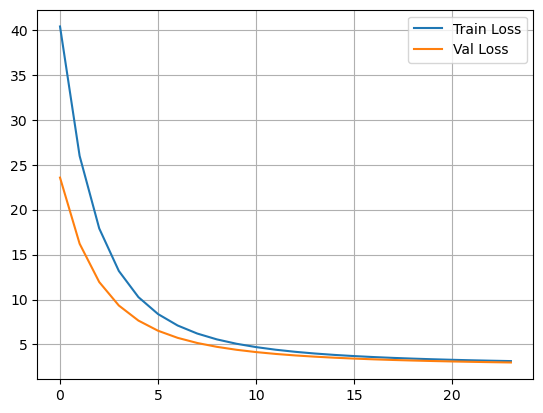

In [10]:
# Define the hyperparameters
num_inputs, num_outputs = X.shape[1], 1
num_epochs = 25
lr = 0.1

tpc = 3
fpc = 3
tnc = 0

# Instantiate the model, opt, criterion
logreg = LogisticRegression(num_inputs, num_outputs)
optimizer = torch.optim.Adam(logreg.parameters(), lr=lr)
# criterion = torch.nn.BCEWithLogitsLoss()

def criterion(y_pred, y_true, fnc):
    y_true = y_true.float()
    
    y_pred = torch.sigmoid(y_pred)
    
    loss = (y_true * (y_pred * tpc + (1 - y_pred) * fnc)) + ((1 - y_true) * (y_pred * fpc + (1 - y_pred) * tnc))
    
    return loss.mean()
    

train_losses = []
val_losses = []

# Train the model
for i in range(num_epochs):
    logreg.train()
    cost = 0
    for (X, y_true, fnc) in train_loader:
        optimizer.zero_grad()
        
        y_pred = logreg(X)
        
        loss = criterion(y_pred, y_true, fnc)
        
        cost += loss.item()
        
        loss.backward()
        optimizer.step()
        
        
    cost/=len(train_loader)
    train_losses.append(cost)
    
    val_cost = 0
    for (X, y_true, fnc) in val_loader:
        logreg.eval()
        
        y_pred = logreg(X)
        loss = criterion(y_pred, y_true, fnc)
        
        val_cost += loss.item()
        
        
    val_cost/=len(val_loader)
    val_losses.append(val_cost)
    
    print(f"Epoch {i}: train loss = {cost}, validation loss = {val_cost}")

# Plot the losses
plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Val Loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
from sklearn.metrics import classification_report

logreg.eval()

train_true = []
train_pred = []

val_true = []
val_pred = []

test_true = []
test_pred = []

threshold = 0.5

for (X, y_true, fnc) in train_loader:
    y_pred = torch.sigmoid(logreg(X)) 
    
    y_pred_binary = (y_pred >= threshold).float()

    # print(y_pred)
    # print(y_true)
    # break

    train_true.extend(y_true) 
    train_pred.extend(y_pred_binary)

print("Train Data Results")
print(classification_report(train_true, train_pred, digits=4))


for (X, y_true, fnc) in val_loader:
    y_pred = torch.sigmoid(logreg(X)) 
    
    y_pred_binary = (y_pred >= threshold).float()

    val_true.extend(y_true) 
    val_pred.extend(y_pred_binary)

print("Val Data Results")
print(classification_report(val_true, val_pred, digits=4))


for (X, y_true, fnc) in test_loader:
    y_pred = torch.sigmoid(logreg(X)) 

    y_pred_binary = (y_pred >= threshold).float()

    test_true.extend(y_true) 
    test_pred.extend(y_pred_binary)

print("Test Data Results")
print(classification_report(test_true, test_pred, digits=4))


Train Data Results
              precision    recall  f1-score   support

         0.0     0.9134    0.5743    0.7052     72393
         1.0     0.4671    0.8727    0.6085     30952

    accuracy                         0.6636    103345
   macro avg     0.6902    0.7235    0.6568    103345
weighted avg     0.7797    0.6636    0.6762    103345

Val Data Results
              precision    recall  f1-score   support

         0.0     0.9110    0.5730    0.7035     15563
         1.0     0.4622    0.8677    0.6031      6582

    accuracy                         0.6606     22145
   macro avg     0.6866    0.7203    0.6533     22145
weighted avg     0.7776    0.6606    0.6736     22145

Test Data Results
              precision    recall  f1-score   support

         0.0     0.9159    0.5825    0.7121     15598
         1.0     0.4674    0.8726    0.6087      6548

    accuracy                         0.6683     22146
   macro avg     0.6916    0.7276    0.6604     22146
weighted avg     0.7

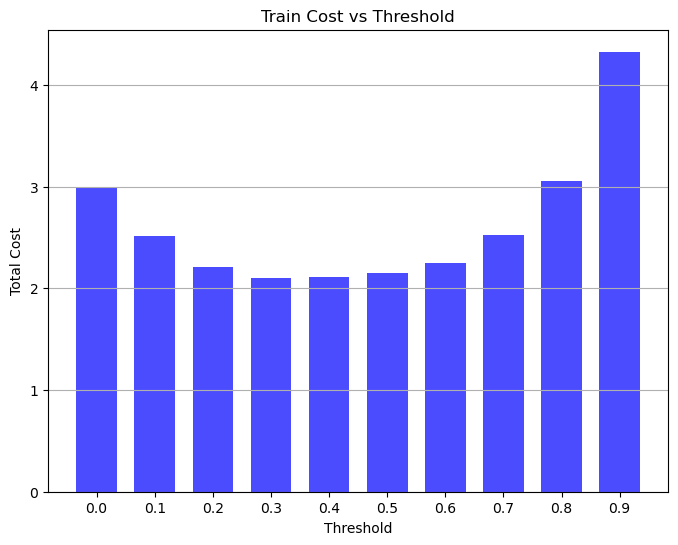

In [17]:
tpc = 3      
fpc = 3      
tnc = 0      

thresholds = np.linspace(0.0, 0.9, 10)  
costs = []  

logreg.eval()


for threshold in thresholds:
    total_cost = 0  
    
    with torch.no_grad():
        for (X, y_true, fnc) in train_loader:
            X = X.to(torch.float32)
            
            y_pred = torch.sigmoid(logreg(X)) 
            
            y_pred_binary = (y_pred >= threshold).float()
            
            batch_cost = torch.sum(
                y_true * (y_pred_binary * tpc + (1 - y_pred_binary) * fnc) +
                (1 - y_true) * (y_pred_binary * fpc + (1 - y_pred_binary) * tnc)
            ).item()  
            
            total_cost += batch_cost  
    
    costs.append(total_cost)  

costs = np.array(costs)
costs /= len(train_loader.dataset)

plt.figure(figsize=(8,6))
plt.bar(thresholds, costs, width=0.07, color='b', alpha=0.7)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Train Cost vs Threshold")
plt.xticks(thresholds)
plt.grid(axis='y')
plt.show()

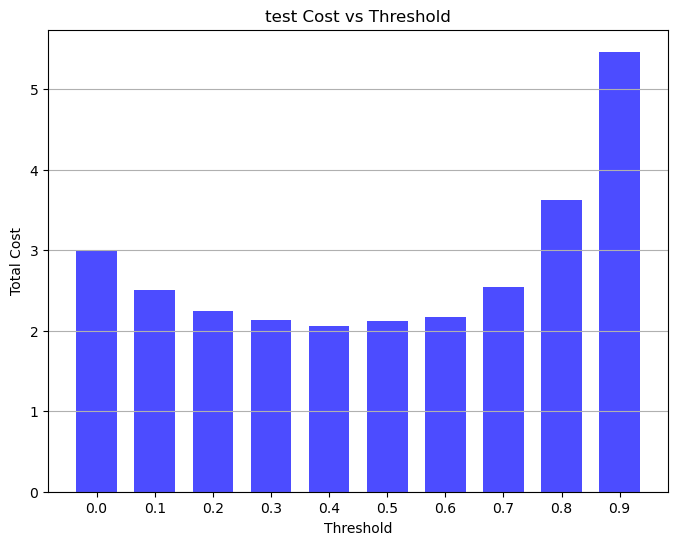

In [19]:
tpc = 3      
fpc = 3      
tnc = 0      

thresholds = np.linspace(0.0, 0.9, 10)  
costs = []  

logreg.eval()


for threshold in thresholds:
    total_cost = 0  
    
    with torch.no_grad():
        for (X, y_true, fnc) in test_loader:
            X = X.to(torch.float32)
            
            y_pred = torch.sigmoid(logreg(X)) 
            
            y_pred_binary = (y_pred >= threshold).float()
            
            batch_cost = torch.sum(
                y_true * (y_pred_binary * tpc + (1 - y_pred_binary) * fnc) +
                (1 - y_true) * (y_pred_binary * fpc + (1 - y_pred_binary) * tnc)
            ).item()  
            
            total_cost += batch_cost  
    
    costs.append(total_cost)  

costs = np.array(costs)
costs /= len(test_loader.dataset)

plt.figure(figsize=(8,6))
plt.bar(thresholds, costs, width=0.07, color='b', alpha=0.7)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("test Cost vs Threshold")
plt.xticks(thresholds)
plt.grid(axis='y')
plt.show()


gen	nevals	min        	avg       
0  	50    	1.98322e+06	8.7926e+06
1  	27    	1.12701e+06	5.53897e+06
2  	32    	611561     	3.28922e+06
3  	33    	487982     	1.58235e+06
4  	35    	337979     	1.02098e+06
5  	35    	337979     	704315     
6  	30    	315528     	561329     
7  	31    	315528     	449360     
8  	38    	305069     	391965     
9  	34    	290653     	348101     
10 	32    	290653     	322381     
11 	34    	297201     	313987     
12 	39    	285320     	309336     
13 	24    	278670     	300544     
14 	28    	281439     	293406     
15 	27    	274480     	287259     
16 	38    	269844     	285096     
17 	35    	269110     	278373     
18 	36    	267807     	274778     
19 	33    	265362     	271621     
20 	28    	258750     	269009     
21 	30    	258750     	266160     
22 	23    	255626     	264085     
23 	39    	255357     	261424     
24 	35    	248280     	258819     
25 	26    	248280     	256259     
26 	27    	246918     	254256     
27 	35    	246918     

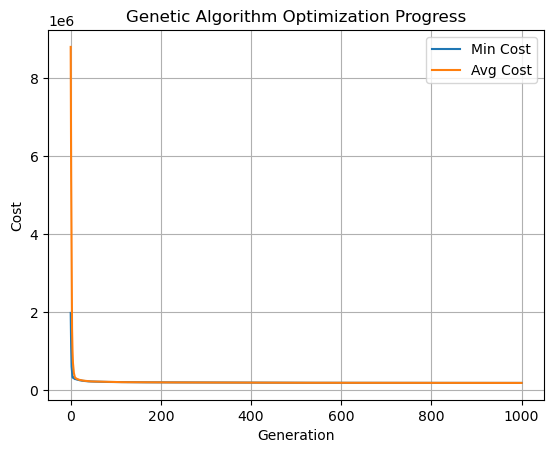

In [9]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

tpc = 3
fpc = 3
tnc = 0

class LogisticRegression(torch.nn.Module):
    def __init__(self, num_inputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_inputs, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x)).squeeze()

num_features = next(iter(train_loader))[0].shape[1] 
logreg_gen = LogisticRegression(num_features)

POP_SIZE = 50
GENS = 1000
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.5

def evaluate(individual):
    with torch.no_grad():
    
        weights, bias = torch.tensor(individual[:-1]), torch.tensor(individual[-1])
        logreg_gen.linear.weight.data = weights.reshape(1, -1)
        logreg_gen.linear.bias.data = bias.reshape(1)

        total_cost = 0
        for X, y_true, fnc in train_loader:
            X, y_true = X.float(), y_true.float()
            y_pred = logreg_gen(X)

        
            batch_cost = torch.sum(
                y_true * (y_pred * tpc + (1 - y_pred) * fnc) +
                (1 - y_true) * (y_pred * fpc + (1 - y_pred) * tnc)
            ).item()
            
            total_cost += batch_cost

    return (total_cost,) 

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=num_features + 1) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5) 
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=MUTATION_RATE) 
toolbox.register("select", tools.selTournament, tournsize=3) 
toolbox.register("evaluate", evaluate)

pop = toolbox.population(n=POP_SIZE)
hall_of_fame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE, ngen=GENS, 
                               stats=stats, halloffame=hall_of_fame, verbose=True)

best_individual = hall_of_fame[0]
print(f"Best Cost: {evaluate(best_individual)}")

gen, min_cost, avg_cost = log.select("gen", "min", "avg")
plt.plot(gen, min_cost, label="Min Cost")
plt.plot(gen, avg_cost, label="Avg Cost")
plt.xlabel("Generation")
plt.ylabel("Cost")
plt.title("Genetic Algorithm Optimization Progress")
plt.legend()
plt.grid()
plt.show()


In [10]:
# Extract best weights and bias
best_weights = torch.tensor(best_individual[:-1]).reshape(1, -1)  # All except last element
best_bias = torch.tensor(best_individual[-1]).reshape(1)  # Last element

# Assign to model
logreg_gen.linear.weight.data = best_weights
logreg_gen.linear.bias.data = best_bias

# Save the model
torch.save(logreg_gen.state_dict(), "logreg_model_gen2.pth")

/tmp/ipykernel_13439/3280268110.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logreg_gen.load_state_dict(torch.load("logreg_model_gen2.pth"))


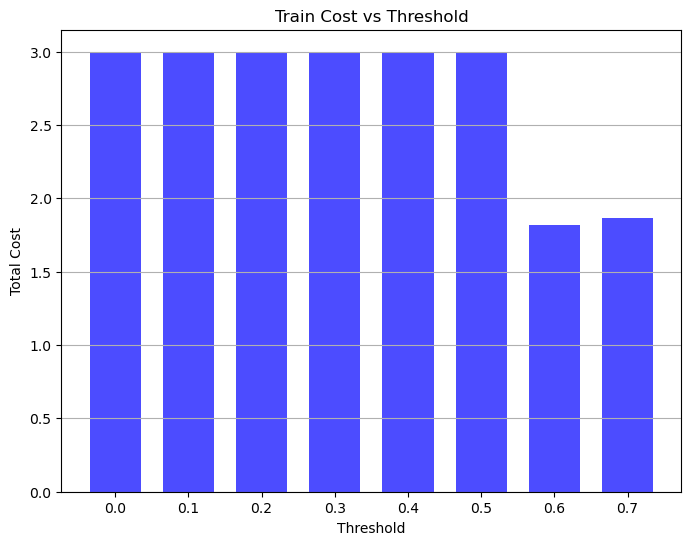

In [15]:
# load the model
num_features = next(iter(train_loader))[0].shape[1] 
logreg_gen = LogisticRegression(num_features)
logreg_gen.load_state_dict(torch.load("logreg_model_gen2.pth"))


tpc = 3      
fpc = 3      
tnc = 0      

thresholds = np.linspace(0.0, 0.7, 8)  
# thresholds = [0]
costs = []  

logreg_gen.eval()


for threshold in thresholds:
    total_cost = 0  
    
    with torch.no_grad():
        for (X, y_true, fnc) in train_loader:
            X = X.to(torch.float32)
            
            y_pred = torch.sigmoid(logreg_gen(X)) 
            
            y_pred_binary = (y_pred >= threshold).float()
            
            batch_cost = torch.sum(
                y_true * (y_pred_binary * tpc + (1 - y_pred_binary) * fnc) +
                (1 - y_true) * (y_pred_binary * fpc + (1 - y_pred_binary) * tnc)
            ).item()  
            
            total_cost += batch_cost  
    
    costs.append(total_cost)  

costs = np.array(costs)
costs /= len(train_loader.dataset)

plt.figure(figsize=(8,6))
plt.bar(thresholds, costs, width=0.07, color='b', alpha=0.7)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Train Cost vs Threshold")
plt.xticks(thresholds)
plt.grid(axis='y')
plt.show()


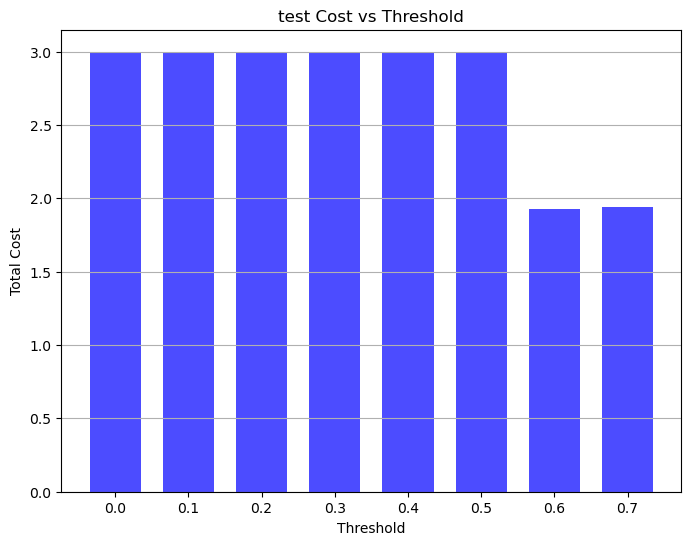

In [16]:
tpc = 3      
fpc = 3      
tnc = 0      

thresholds = np.linspace(0.0, 0.7, 8)  
# thresholds = [0]
costs = []  

logreg_gen.eval()


for threshold in thresholds:
    total_cost = 0  
    
    with torch.no_grad():
        for (X, y_true, fnc) in test_loader:
            X = X.to(torch.float32)
            
            y_pred = torch.sigmoid(logreg_gen(X)) 
            
            y_pred_binary = (y_pred >= threshold).float()
            
            batch_cost = torch.sum(
                y_true * (y_pred_binary * tpc + (1 - y_pred_binary) * fnc) +
                (1 - y_true) * (y_pred_binary * fpc + (1 - y_pred_binary) * tnc)
            ).item()  
            
            total_cost += batch_cost  
    
    costs.append(total_cost)  

costs = np.array(costs)
costs /= len(test_loader.dataset)

plt.figure(figsize=(8,6))
plt.bar(thresholds, costs, width=0.07, color='b', alpha=0.7)
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("test Cost vs Threshold")
plt.xticks(thresholds)
plt.grid(axis='y')
plt.show()


In [18]:
from sklearn.metrics import classification_report

logreg_gen.eval()

train_true = []
train_pred = []

val_true = []
val_pred = []

test_true = []
test_pred = []

threshold = 0.6

for (X, y_true, fnc) in train_loader:
    y_pred = torch.sigmoid(logreg_gen(X)) 
    
    y_pred_binary = (y_pred >= threshold).float()

    # print(y_pred)
    # print(y_true)
    # break

    train_true.extend(y_true) 
    train_pred.extend(y_pred_binary)

print("Train Data Results")
print(classification_report(train_true, train_pred, digits=4))


for (X, y_true, fnc) in val_loader:
    y_pred = torch.sigmoid(logreg_gen(X)) 
    
    y_pred_binary = (y_pred >= threshold).float()

    val_true.extend(y_true) 
    val_pred.extend(y_pred_binary)

print("Val Data Results")
print(classification_report(val_true, val_pred, digits=4))


for (X, y_true, fnc) in test_loader:
    y_pred = torch.sigmoid(logreg_gen(X)) 

    y_pred_binary = (y_pred >= threshold).float()

    test_true.extend(y_true) 
    test_pred.extend(y_pred_binary)

print("Test Data Results")
print(classification_report(test_true, test_pred, digits=4))


Train Data Results
              precision    recall  f1-score   support

         0.0     0.9700    0.6295    0.7635     72556
         1.0     0.5222    0.9541    0.6750     30789

    accuracy                         0.7262    103345
   macro avg     0.7461    0.7918    0.7192    103345
weighted avg     0.8366    0.7262    0.7371    103345

Val Data Results
              precision    recall  f1-score   support

         0.0     0.9678    0.6292    0.7626     15451
         1.0     0.5265    0.9517    0.6780      6694

    accuracy                         0.7267     22145
   macro avg     0.7472    0.7905    0.7203     22145
weighted avg     0.8344    0.7267    0.7370     22145

Test Data Results
              precision    recall  f1-score   support

         0.0     0.9682    0.6303    0.7636     15547
         1.0     0.5220    0.9512    0.6741      6599

    accuracy                         0.7260     22146
   macro avg     0.7451    0.7908    0.7188     22146
weighted avg     0.8

gen	nevals	min    	avg    
0  	200   	6.78184	80.3377
1  	125   	6.27434	80.6851
2  	119   	5.01506	80.9672
3  	115   	4.42742	80.9602
4  	126   	4.42742	81.0106
5  	123   	4.31383	80.9391
6  	128   	4.31383	80.837 
7  	149   	4.68767	80.8974
8  	131   	4.67541	80.9456
9  	126   	4.67541	80.7444
10 	135   	4.44038	80.5144
11 	140   	4.44038	80.5744
12 	119   	4.44038	80.1014
13 	126   	4.44038	79.8802
14 	130   	4.534  	79.8943
15 	145   	4.51456	79.8651
16 	133   	4.39919	80.2446
17 	133   	4.39754	80.179 
18 	138   	4.39754	80.5878
19 	125   	4.21208	80.4606
20 	136   	4.39592	80.2027
21 	135   	4.39592	80.2182
22 	113   	4.39592	80.4446
23 	119   	4.28963	80.5983
24 	133   	3.97688	80.6965
25 	138   	3.97143	80.6052
26 	137   	3.94122	80.7229
27 	136   	4.06836	80.6058
28 	129   	4.06401	80.5251
29 	123   	4.06401	80.6683
30 	136   	4.06401	80.5668
31 	136   	4.06401	80.5765
32 	123   	4.04528	80.5985
33 	134   	3.99196	80.8125
34 	122   	3.99196	80.6663
35 	121   	3.99196	80.7248
3

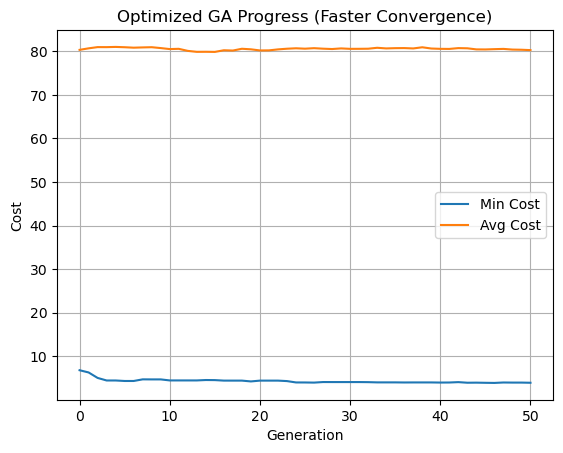

In [9]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

tpc = 3
fpc = 3
tnc = 0

class LogisticRegression(torch.nn.Module):
    def __init__(self, num_inputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_inputs, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x)).squeeze()

num_features = next(iter(train_loader))[0].shape[1]  
logreg_gen = LogisticRegression(num_features)

# Hyperparameters for GA
POP_SIZE = 200  # Increased population size for better diversity
GENS = 50  # Reduce generations to converge faster
MUTATION_RATE = 0.1  # Reduced mutation for stability
CROSSOVER_RATE = 0.6  # Slightly higher crossover rate

def evaluate(individual):
    """Evaluate the cost function using the given individual's weights."""
    with torch.no_grad():
        weights, bias = torch.tensor(individual[:-1]), torch.tensor(individual[-1])
        logreg_gen.linear.weight.data = weights.reshape(1, -1)
        logreg_gen.linear.bias.data = bias.reshape(1)

        total_cost = 0
        num_samples = 0
        for X, y_true, fnc in train_loader:
            X, y_true = X.float(), y_true.float()
            y_pred = logreg_gen(X)

            batch_cost = torch.sum(
                y_true * (y_pred * tpc + (1 - y_pred) * fnc) +
                (1 - y_true) * (y_pred * fpc + (1 - y_pred) * tnc)
            ).item()

            total_cost += batch_cost
            num_samples += len(X)  # Keep track of total samples

    return (total_cost / num_samples,)  # Normalize cost for stability

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=num_features + 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)  # Use Two-Point Crossover for better performance
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=MUTATION_RATE)  # Reduce mutation rate
toolbox.register("select", tools.selBest)  # Use elitism
toolbox.register("evaluate", evaluate)

# Run genetic algorithm
pop = toolbox.population(n=POP_SIZE)
hall_of_fame = tools.HallOfFame(5)  # Store top 5 best individuals
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE, ngen=GENS, 
                               stats=stats, halloffame=hall_of_fame, verbose=True)

best_individual = hall_of_fame[0]
print(f"Best Cost: {evaluate(best_individual)}")

# Plot evolution
gen, min_cost, avg_cost = log.select("gen", "min", "avg")
plt.plot(gen, min_cost, label="Min Cost")
plt.plot(gen, avg_cost, label="Avg Cost")
plt.xlabel("Generation")
plt.ylabel("Cost")
plt.title("Optimized GA Progress (Faster Convergence)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Extract best weights and bias
best_weights = torch.tensor(best_individual[:-1], dtype=torch.float32).reshape(1, -1)  # All except last element
best_bias = torch.tensor(best_individual[-1], dtype=torch.float32).reshape(1)  # Last element

# Assign to the model
logreg_gen.linear.weight.data = best_weights
logreg_gen.linear.bias.data = best_bias

# Save the optimized model
torch.save(logreg_gen.state_dict(), "logreg_model_gen3.pth")

print("Model saved successfully as logreg_model_gen3.pth")
